In [1]:
# In order to have a reference line, a base model will be trained with face cropped and aligned for bonafide vs printed vs screen classes (3 classes).
# - obj: train over FLICKR and eval with FLICKR

# take json files and gather data to training format -> bonafide vs imposter

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import json
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.paths import list_images

from tensorflow.keras.models import Model, load_model
from aikit.graphics.biometric_performance import performance_evaluation
from aikit.graphics.confusion_matrix import (
    plot_confusion_matrix,
    plot_system_confusion_matrix
)
from aikit.graphics.det_plot import DETPlot
from aikit.metadata import __version__ as aikit_ver
from aikit.metrics.det_curve import det_curve_pais, eer_pais
from aikit.metrics.iso_30107_3 import (
    acer,
    apcer_max,
    apcer_pais,
    bpcer,
    bpcer_ap,
    riapar
)
from aikit.metrics.scores import (
    max_error_pais_scores,
    pad_scores,
    split_attack_scores,
    split_scores
)

%load_ext autoreload
%autoreload 2

In [3]:
datapath = '../data/02_intermediate/splunk'
images_list = [*list_images(datapath)]
_classes = ('attack', 'bonafide')
_bf_index = _classes.index('bonafide')

## Variables

In [4]:
bf, att = [], []
_size = (224, 224)
buffer_size = 10101101

for imdir in images_list:
    if _classes[_bf_index] in imdir.split(os.sep): # if 'bonafide' in imdir
        bf.append(imdir)
    else:
        att.append(imdir)

In [5]:
len(bf), len(att)

(5997, 18933)

In [6]:
def plot_confusion_matrix2(cm, class_names, figsize=(16, 16), fontsize=36, draw_zeros=True, cmap="YlGnBu_r"):
    sns.set_context("notebook", font_scale=4)
    style = {
        'axes.facecolor': "#EAEAF2",
        'axes.edgecolor': "white",
        'axes.labelcolor': ".15",
        'figure.facecolor': "white",
        'figure.edgecolor': "white",
        'grid.color': "white",
        'grid.linestyle': "-",
        'legend.facecolor': ".8",
        'legend.edgecolor': ".8",
        'text.color': ".15",
        'xtick.color': ".15",
        'ytick.color': ".15",
        'font.family': "sans-serif",
        'font.sans-serif': "Helvetica",
        'savefig.facecolor': "#EAEAF2",
        'savefig.edgecolor': "#white",
        'savefig.transparent': True,
        'eer.color': ".66"
    }
    sns.set_style(style)

    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    h, w = cm.shape[:2]
    for i in range(w):
        for j in range(h):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = f"{c}/{s[0]}\n{p:.1f}%"
            elif c == 0 and not draw_zeros:
                annot[i, j] = ""
            else:
                annot[i, j] = f"{c}\n{p:.1f}%"
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm.index.name = "Ground Truth"
    cm.columns.name = "Predicted"
    _, ax = plt.subplots(figsize=figsize)
    heatmap = sns.heatmap(cm, cmap=cmap, annot=annot, fmt="",
                          annot_kws={'size': fontsize}, ax=ax)
    fig = heatmap.get_figure()
    fig.patch.set_alpha(0)

    return fig

def _parse_function_with_DA(impath):
    # instantiate augmentation here to overcome "not-changing-random-seed" bug
    # this could lead to an speed decrease or an overheap, dont know
    aug = avg_aug() # think about deleting aug after use
    
    # image reading
    image = tf.io.read_file(impath)
    image = tf.io.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, _size)
    image = tf.cast(image, tf.uint8)
    image = tf.numpy_function(func=aug.augment_image, inp=[image], Tout=tf.uint8)
    image = tf.cast(image, tf.float32)
    image = image / 255.
    # image /= 127.5
    # image -= 1.0
    
    # image = tf.clip_by_value(image, -1, 1)
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[4]
    # 4th element is the class id
    if _cls == 'bonafide':
        lb = tf.cast([0, 1], tf.float32)
    else:
        lb = tf.cast([1, 0], tf.float32)
    
    return image, lb

def _parse_function_without_DA(impath):
    # image reading
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, _size)
    image = image / 255.
    # image /= 127.5
    # image -= 1.0
    
    # image = tf.clip_by_value(image, -1, 1)
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[4]
    # 4th element is the class id
    if _cls == 'bonafide':
        lb = tf.cast([0, 1], tf.float32)
    else:
        lb = tf.cast([1, 0], tf.float32)
    
    return image, lb

# How to make dataset

In [7]:
# def train, test, val sets # done

In [8]:
bf_y = np.ones(len(bf))
att_y = np.zeros(len(att))

# # limit data
# att = att[:len(bf)*2]
# att_y = att_y[:len(bf)*2]

In [9]:
bf_y.shape, att_y.shape

((5997,), (18933,))

In [10]:
X = np.concatenate([bf, att])
y = np.concatenate([bf_y, att_y])

# Test data

In [11]:
test_dataset = tf.cast(X, dtype=tf.string)
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.shuffle(buffer_size)
test_dataset = test_dataset.map(_parse_function_without_DA)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(1)

2022-12-09 12:49:49.819250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 12:49:49.843895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 12:49:49.844595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 12:49:49.845529: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [12]:
len(test_dataset)

24930

/tmp/ipykernel_7254/1265556544.py:2: DeprecationWarning: deprecated
  warnings.warn("deprecated", DeprecationWarning)


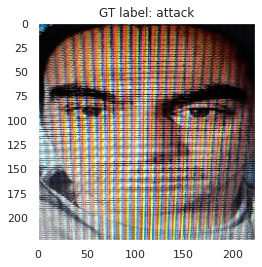

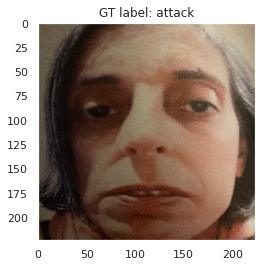

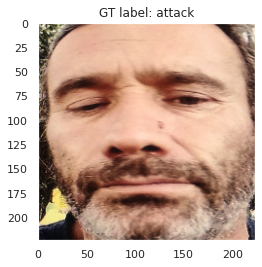

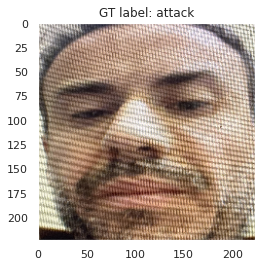

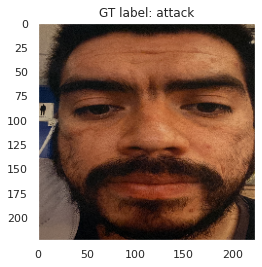

2022-12-09 12:49:51.887505: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
with warnings.catch_warnings():
    warnings.warn("deprecated", DeprecationWarning)
    warnings.simplefilter("ignore")
    
    for bs in test_dataset.take(5):
        im, lb = bs

        _class_argmax = np.argmax(lb[0], axis=-1)
        plt.title(f'GT label: {_classes[_class_argmax]}')
        plt.imshow(im[0])
        plt.grid(False)
        plt.show()

In [14]:
import tensorflow as tf
from math import pi

# ref: https://www.kaggle.com/code/chankhavu/keras-layers-arcface-cosface-adacos/notebook7
# ref: https://github.com/yinguobing/arcface/blob/main/train.py

class L2Normalization(tf.keras.layers.Layer):
    """This layer normalizes the inputs with l2 normalization."""

    def __init__(self, **kwargs):
        super(L2Normalization, self).__init__(**kwargs)

    @tf.function
    def call(self, inputs):
        inputs = tf.nn.l2_normalize(inputs, axis=1)

        return inputs

    def get_config(self):
        config = super().get_config()
        return config

class ArcLayer(tf.keras.layers.Layer):
    """Custom layer for ArcFace.
    This layer is equivalent a dense layer except the weights are normalized.
    """

    def __init__(self, units, kernel_regularizer=None, **kwargs):
        super(ArcLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=[input_shape[-1], self.units],
                                      dtype=tf.float32,
                                      initializer=tf.keras.initializers.HeNormal(),
                                      regularizer=self.kernel_regularizer,
                                      trainable=True,
                                      name='kernel')
        self.built = True

    @tf.function
    def call(self, inputs):
        weights = tf.nn.l2_normalize(self.kernel, axis=0)
        return tf.matmul(inputs, weights)

    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units,
                       "kernel_regularizer": self.kernel_regularizer})
        return config

class ArcLoss(tf.keras.losses.Loss):
    """Additive angular margin loss.
    Original implementation: https://github.com/luckycallor/InsightFace-tensorflow
    """

    def __init__(self, margin=0.5, scale=64, name="arcloss"):
        """Build an additive angular margin loss object for Keras model."""
        super().__init__(name=name)
        self.margin = margin
        self.scale = scale
        self.threshold = tf.math.cos(pi - margin)
        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)

        # Safe margin: https://github.com/deepinsight/insightface/issues/108
        self.safe_margin = self.sin_m * margin

    @tf.function
    def call(self, y_true, y_pred):

        # Calculate the cosine value of theta + margin.
        cos_t = y_pred
        sin_t = tf.math.sqrt(1 - tf.math.square(cos_t))

        cos_t_margin = tf.where(cos_t > self.threshold,
                                cos_t * self.cos_m - sin_t * self.sin_m,
                                cos_t - self.safe_margin)

        # The labels here had already been onehot encoded.
        mask = y_true
        cos_t_onehot = cos_t * mask
        cos_t_margin_onehot = cos_t_margin * mask

        # Calculate the final scaled logits.
        logits = (cos_t + cos_t_margin_onehot - cos_t_onehot) * self.scale

        losses = tf.nn.softmax_cross_entropy_with_logits(y_true, logits)

        return losses

    def get_config(self):
        config = super(ArcLoss, self).get_config()
        config.update({"margin": self.margin, "scale": self.scale})
        return config

In [15]:
model = load_model(
    'models/E030-1.5597.hdf5',
    compile=False, 
    custom_objects={
        'L2Normalization': L2Normalization, 
        'ArcLayer': ArcLayer,
        'L2': tf.keras.regularizers.L2,
        'ArcLoss': ArcLoss,
    }
)

In [16]:
# model.summary()

In [17]:
f'{model.count_params():,}'

'2,260,544'

In [18]:
model.compile(
    optimizer='rmsprop', 
    loss=ArcLoss(), 
    metrics=[
        'acc', 
        # tf.keras.metrics.Recall(),
    ], 
)

In [19]:
model.evaluate(test_dataset)

2022-12-09 12:49:54.690559: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-12-09 12:49:55.057958: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-09 12:49:55.059008: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


24930/24930 [==============================] - 1020s 41ms/step - loss: 3.5079 - acc: 0.8834


[3.5079352855682373, 0.8833935260772705]

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import det_curve, DetCurveDisplay, roc_curve, RocCurveDisplay

In [21]:
y_true, y_pred, y_score = [], [], []

for im, lb in tqdm(test_dataset):
    lb = np.argmax(lb, axis=-1)[0]
    scores = model.predict(im)[0]
    pred = np.argmax(scores)
    
    y_true.append(lb)
    y_pred.append(pred)
    y_score.append(scores[_bf_index])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24930/24930 [11:06<00:00, 37.38it/s]


In [22]:
clf = classification_report(y_true=y_true, y_pred=y_pred, digits=4, target_names=_classes)

In [23]:
print(clf)

              precision    recall  f1-score   support

      attack     0.8744    0.9885    0.9279     18933
    bonafide     0.9382    0.5516    0.6947      5997

    accuracy                         0.8834     24930
   macro avg     0.9063    0.7700    0.8113     24930
weighted avg     0.8897    0.8834    0.8718     24930



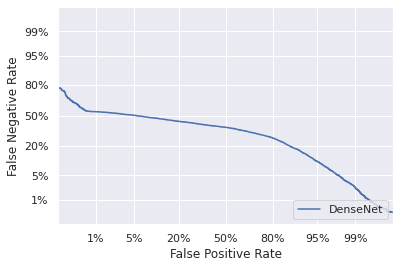

In [24]:
# fpr, fnr, thresholds = det_curve(y_true, coded_y_score, pos_label=_bf_index)
fpr, fnr, thresholds = det_curve(y_true, y_score, pos_label=_bf_index)
fig = DetCurveDisplay(fpr=fpr, fnr=fnr, estimator_name='DenseNet')
fig.plot()
plt.show()

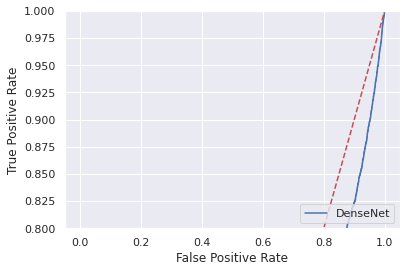

In [25]:
# fpr, fnr, thresholds = det_curve(y_true, coded_y_score, pos_label=_bf_index)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=_bf_index)
fig = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='DenseNet')
fig.plot()
plt.ylim([0.8, 1.0])
plt.plot([0, 1], 'r--')
plt.show()

# CM with best DEER threshold

[]

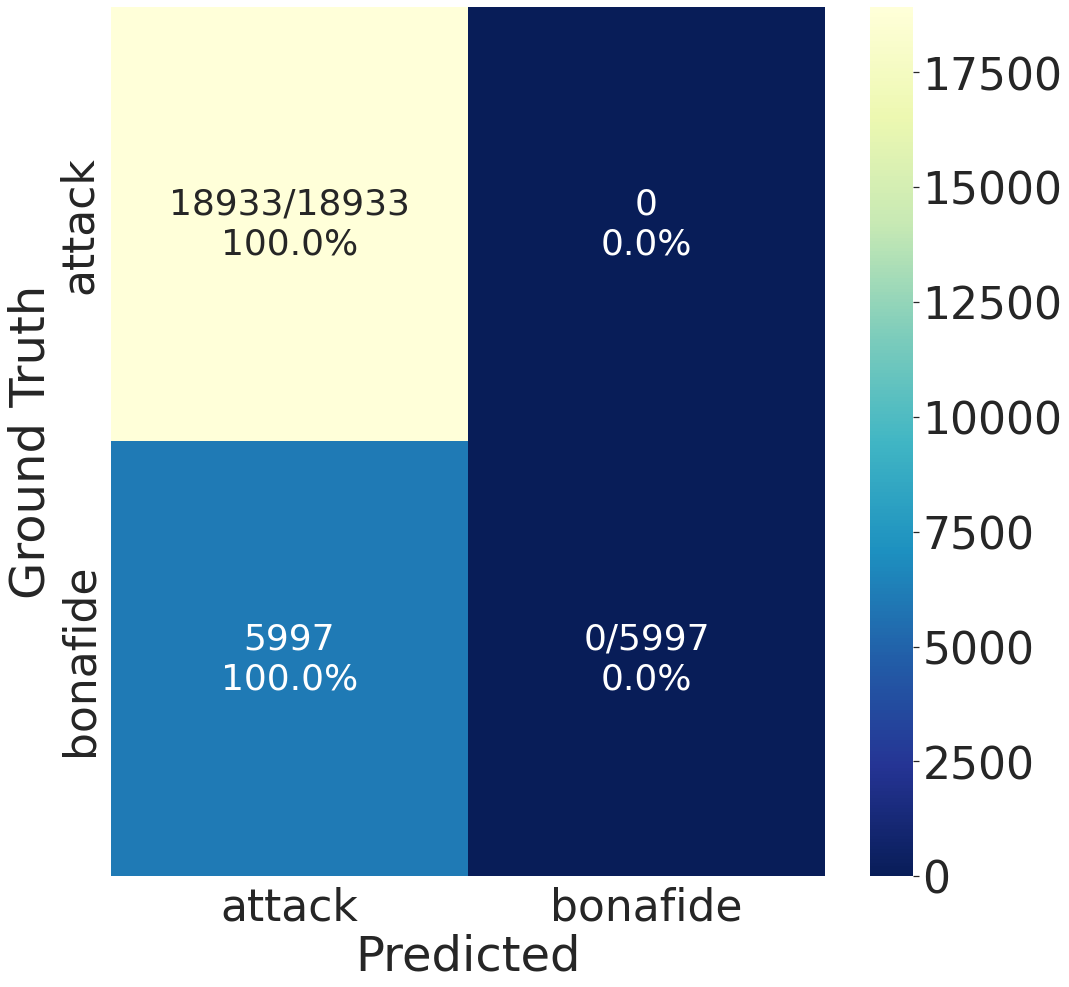

In [36]:
y_pred_2 = (y_score >= 0.31882500000001873).astype(np.uint8)
cm = confusion_matrix(y_true, y_pred_2)
fig = plot_confusion_matrix2(cm, _classes)
plt.plot()

# CM with new DEER threshold

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


[]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


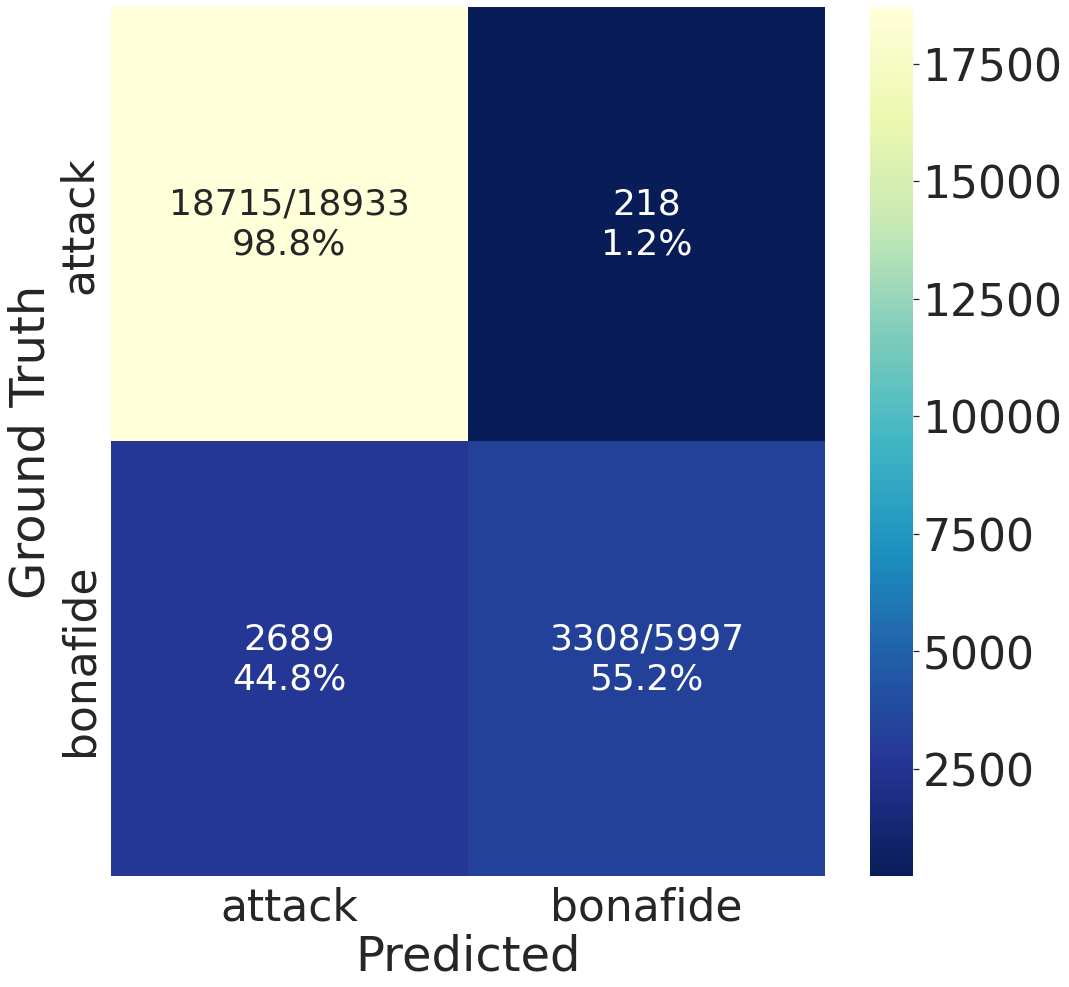

In [27]:
cm = confusion_matrix(y_true, y_pred)
fig = plot_confusion_matrix2(cm, _classes)
plt.plot()

/home/u2/andres/thesis-msc-2022/notebooks/aikit/graphics/det_plot.py:244: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


attack EER: 39.209169738317115
attack EER Threshold: -0.9627730247876645



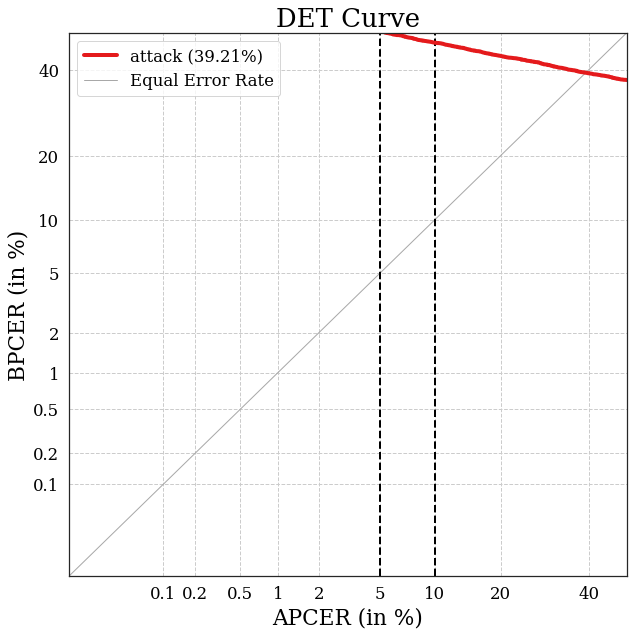

In [28]:
det = DETPlot(context="notebook")

y_score = np.array(y_score)
y_pred = np.array(y_pred)
y_true = np.array(y_true)

attack_scores = y_score[ y_true != _bf_index ]
bonafide_scores = y_score[ y_true == _bf_index ]

det.set_system(attack_scores, bonafide_scores, label=f"attack")

det_plot = det.plot()

for system in det.systems:
    ths = det.systems[system]['eer_thres']
    _eer = det.systems[system]['eer']
    print(f'{system} EER: {_eer}')
    print(f'{system} EER Threshold: {ths}\n')

In [29]:
threshold = ths
attack_scores, bonafide_scores, attack_true, bonafide_true = split_scores(y_true, y_score, bonafide_label=_bf_index)
pais_attack_scores = split_attack_scores(attack_true, attack_scores)

det_pais = det_curve_pais(attack_true, attack_scores, bonafide_scores)
eer_pais_ = eer_pais(det_pais, percentage=True)

max_eer_pais = max(eer_pais_, key=eer_pais_.get)
max_attack_scores, max_attack_pais = max_error_pais_scores(attack_true, attack_scores, threshold=threshold)

acer_ = acer(attack_true, attack_scores, bonafide_scores, threshold=threshold)
apcer_ = apcer_pais(attack_true, attack_scores, threshold=threshold, percentage=True)
bpcer_ = bpcer(bonafide_scores, threshold=threshold)
bpcer10, bpcer10thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 10, percentage=True)
bpcer20, bpcer20thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 20, percentage=True)
bpcer50, bpcer50thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 50, percentage=True)
bpcer100, bpcer100thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 100, percentage=True)
bpcer200, bpcer200thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 200, percentage=True)
bpcer500, bpcer500thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 500, percentage=True)
bpcer1000, bpcer1000thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 1000, percentage=True)
bpcer10000, bpcer10000thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 10000, percentage=True)
riapar_ = riapar(max_attack_scores, bonafide_scores, attack_threshold=threshold, bonafide_threshold=threshold)

print(
    f"        Bona Fide label: {_bf_index}: {_classes[_bf_index]}\n"
    f"            Threshold t: {threshold}\n"
    "--------------------------------------------\n"
    f"           Max EER PAIS: {max_eer_pais}: {_classes[max_eer_pais]}\n"
    f"                 EER[{max_eer_pais}]: {eer_pais_[max_eer_pais][0]}%\n"
    f"       EER threshold[{max_eer_pais}]: {eer_pais_[max_eer_pais][1]}\n"
    "--------------------------------------------\n"
    f"      Max APCER PAIS(t): {max_attack_pais}: {_classes[max_attack_pais]}\n"
    f"                ACER(t): {acer_*100}%\n"
    f"               APCER(t): {apcer_}%\n"
    f"               BPCER(t): {bpcer_*100}%\n"
    f"              RIAPAR(t): {riapar_*100}%\n"
    f"                 EER[{max_attack_pais}]: {eer_pais_[max_attack_pais][0]}%\n"
    f"       EER threshold[{max_attack_pais}]: {eer_pais_[max_attack_pais][1]}\n"
    "--------------------------------------------\n"
    f"   BPCER10(APCER=10.0%): {bpcer10}%, {bpcer10thres}\n"
    f"   BPCER20(APCER=5.00%): {bpcer20}%, {bpcer20thres}\n"
    f"   BPCER50(APCER=2.00%): {bpcer50}%, {bpcer50thres}\n"
    f"  BPCER100(APCER=1.00%): {bpcer100}%, {bpcer100thres}\n"
    f"   BPCER200(APCER=0.50%): {bpcer200}%, {bpcer200thres}\n"
    f"   BPCER500(APCER=0.20%): {bpcer500}%, {bpcer500thres}\n"
    f" BPCER1000(APCER=0.10%): {bpcer1000}%, {bpcer1000thres}\n"
    f"BPCER10000(APCER=0.01%): {bpcer10000}%, {bpcer10000thres}\n"
)

        Bona Fide label: 1: bonafide
            Threshold t: -0.9627730247876645
--------------------------------------------
           Max EER PAIS: 0: attack
                 EER[0]: 39.200133515076786%
       EER threshold[0]: -0.9627580247876644
--------------------------------------------
      Max APCER PAIS(t): 0: attack
                ACER(t): 39.204805487305%
               APCER(t): {0: 39.206676173876296}%
               BPCER(t): 39.2029348007337%
              RIAPAR(t): 78.40961097461%
                 EER[0]: 39.200133515076786%
       EER threshold[0]: -0.9627580247876644
--------------------------------------------
   BPCER10(APCER=10.0%): 47.30698682674671%, -0.9247680247874155
   BPCER20(APCER=5.00%): 50.35851258962815%, -0.9025380247872699
   BPCER50(APCER=2.00%): 53.02651325662831%, -0.8816880247871333
  BPCER100(APCER=1.00%): 54.277138569284645%, -0.8718880247870691
   BPCER200(APCER=0.50%): 58.21243955310989%, -0.8418880247868725
   BPCER500(APCER=0.20%): 73.5

In [30]:
# tsne exploration

In [31]:
# x = model.get_layer('max_pool').output
x = model.layers[-2].output
new_model = Model(inputs=[model.input], outputs=[x])

In [32]:
embs, lbs = [], []

for im, lb in tqdm(test_dataset):
    pred = new_model.predict(im)[0]
    embs.append(pred)
    lbs.append(np.argmax(lb[0]))

embs, lbs = np.array(embs), np.array(lbs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24930/24930 [10:46<00:00, 38.54it/s]


In [33]:
from sklearn.manifold import TSNE

In [34]:
tsne = TSNE(n_components=2, verbose=1, random_state=42)
comps = tsne.fit_transform(embs)

/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/u2/miniconda3/envs/msc-pad/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 24930 samples in 0.015s...
[t-SNE] Computed neighbors for 24930 samples in 20.647s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24930
[t-SNE] Computed conditional probabilities for sample 2000 / 24930
[t-SNE] Computed conditional probabilities for sample 3000 / 24930
[t-SNE] Computed conditional probabilities for sample 4000 / 24930
[t-SNE] Computed conditional probabilities for sample 5000 / 24930
[t-SNE] Computed conditional probabilities for sample 6000 / 24930
[t-SNE] Computed conditional probabilities for sample 7000 / 24930
[t-SNE] Computed conditional probabilities for sample 8000 / 24930
[t-SNE] Computed conditional probabilities for sample 9000 / 24930
[t-SNE] Computed conditional probabilities for sample 10000 / 24930
[t-SNE] Computed conditional probabilities for sample 11000 / 24930
[t-SNE] Computed conditional probabilities for sample 12000 / 24930
[t-SNE] Computed conditional probabilities for sa

/tmp/ipykernel_7254/196958739.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

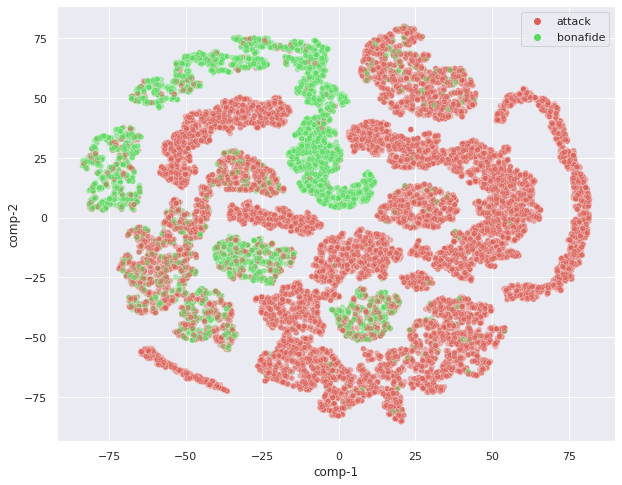

In [35]:
df = pd.DataFrame()
df["y"] = lbs
df["comp-1"] = comps[:,0]
df["comp-2"] = comps[:,1]
df['y2'] = df['y'].apply(lambda x: 'attack' if x == 0 else 'bonafide')


sns.set()
fig = plt.figure(figsize=(10, 8))

sns.scatterplot(
    x="comp-1", y="comp-2", hue=df.y2.tolist(),
    # hue='y2',
    legend='full',
    palette=sns.color_palette("hls", 3), alpha=0.45,
    data=df, 
)

# plt.legend(_classes)